# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [95]:
# Import all of the packages

import pandas as pd
import numpy as np
import requests 
import re
import os 
import datetime
import matplotlib.pyplot as plt 
import seaborn as sns
import json
%matplotlib inline

In [96]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

response = requests.get(url)

with open (url.split('/')[-1] , mode = 'wb') as outfile:
    outfile.write(response.content)


In [97]:
#Read  file 
archive_df = pd.read_csv('twitter-archive-enhanced-2.csv')

images_df = pd.read_csv('image-predictions.tsv' , sep = '\t')

tweet_df = pd.read_json('tweet-json (1).zip',lines = True)



In [98]:
#Read CSV file 
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [99]:
# load the twitter-archive-enhanced.csv into a DataFrame
df = pd.read_csv("twitter-archive-enhanced-2.csv")
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [100]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

response = requests.get(url)

with open (url.split('/')[-1] , mode = 'wb') as outfile:
    outfile.write(response.content)

In [101]:
tweet_df.head()


,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,0.0,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,NaN,...,0.0,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,0.0,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,NaN,...,0.0,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,NaN,...,0.0,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [102]:
print(tweet_df.info())
tweet_df.shape[0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2354 non-null datetime64[ns]
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
favorite_count                   2354 non-null int64
favorited                        2354 non-null bool
full_text                        2354 non-null object
geo                              0 non-null float64
id                               2354 non-null int64
id_str                           2354 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 n

2354

# tweetdf is loaded and we can see that in very quick look there are many columns and missing valuse.

tweetdf has 2354 entries

# Assessing Data

In [103]:

Assessing_tweet = pd.merge(tweet_df, archive_df , left_on='id' , right_on='tweet_id')

In [104]:
Assessing_tweet

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,NaN,...,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,NaN,...,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,NaN,...,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,NaN,NaN,2017-07-29 00:08:17,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891087942176911360, 'id_str'...",20562,False,Here we have a majestic great white breaching ...,NaN,...,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,NaN,NaN,2017-07-28 16:27:12,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890971906207338496, 'id_str'...",12041,False,Meet Jax. He enjoys ice cream so much he gets ...,NaN,...,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,NaN,NaN,2017-07-28 00:22:40,"[0, 118]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890729118844600320, 'id_str'...",56848,False,When you watch your owner call another dog a g...,NaN,...,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,NaN,NaN,2017-07-27 16:25:51,"[0, 122]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 890609177319665665, 'id_str'...",28226,False,This is Zoey. She doesn't want to be one of th...,NaN,...,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,NaN,NaN,2017-07-26 15:59:51,"[0, 133]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890240245463175168, 'id_str'...",32467,False,This is Cassie. She is a college pup. Studying...,NaN,...,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [105]:
Assessing_tweet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2354 entries, 0 to 2353
Data columns (total 48 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2354 non-null datetime64[ns]
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
favorite_count                   2354 non-null int64
favorited                        2354 non-null bool
full_text                        2354 non-null object
geo                              0 non-null float64
id                               2354 non-null int64
id_str                           2354 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id_x          78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id_x            78 non-null float64
in_reply_to_user_id_str          78 n

 id should be string not intger
we have 179 tweets that are retweeted need to drop

In [106]:

images_df = pd.read_csv('image-predictions.tsv' , sep = '\t')


In [107]:
#view the first 5 rows in archive_df data
archive_df.head(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [108]:
Assessing_tweet.describe()

,contributors,coordinates,favorite_count,geo,id,id_str,in_reply_to_status_id_x,in_reply_to_status_id_str,in_reply_to_user_id_x,in_reply_to_user_id_str,...,quoted_status_id,quoted_status_id_str,retweet_count,tweet_id,in_reply_to_status_id_y,in_reply_to_user_id_y,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,0.0,0.0,2354.000000,0.0,2.354000e+03,2.354000e+03,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,...,2.900000e+01,2.900000e+01,2354.000000,2.354000e+03,7.800000e+01,7.800000e+01,1.790000e+02,1.790000e+02,2354.000000,2354.00000
mean,NaN,NaN,8080.968564,NaN,7.426978e+17,7.426978e+17,7.455079e+17,7.455079e+17,2.014171e+16,2.014171e+16,...,8.162686e+17,8.162686e+17,3164.797366,7.426978e+17,7.455079e+17,2.014171e+16,7.714009e+17,1.255572e+16,13.127018,10.45582
std,NaN,NaN,11814.771334,NaN,6.852812e+16,6.852812e+16,7.582492e+16,7.582492e+16,1.252797e+17,1.252797e+17,...,6.164161e+16,6.164161e+16,5284.770364,6.852812e+16,7.582492e+16,1.252797e+17,6.211568e+16,9.652124e+16,45.896135,6.74809
min,NaN,NaN,0.000000,NaN,6.660209e+17,6.660209e+17,6.658147e+17,6.658147e+17,1.185634e+07,1.185634e+07,...,6.721083e+17,6.721083e+17,0.000000,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.00000
25%,NaN,NaN,1415.000000,NaN,6.783975e+17,6.783975e+17,6.757419e+17,6.757419e+17,3.086374e+08,3.086374e+08,...,7.888183e+17,7.888183e+17,624.500000,6.783975e+17,6.757419e+17,3.086374e+08,7.157203e+17,4.196984e+09,10.000000,10.00000
50%,NaN,NaN,3603.500000,NaN,7.194596e+17,7.194596e+17,7.038708e+17,7.038708e+17,4.196984e+09,4.196984e+09,...,8.340867e+17,8.340867e+17,1473.500000,7.194596e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.00000
75%,NaN,NaN,10122.250000,NaN,7.993058e+17,7.993058e+17,8.257804e+17,8.257804e+17,4.196984e+09,4.196984e+09,...,8.664587e+17,8.664587e+17,3652.000000,7.993058e+17,8.257804e+17,4.196984e+09,8.201334e+17,4.196984e+09,12.000000,10.00000
max,NaN,NaN,132810.000000,NaN,8.924206e+17,8.924206e+17,8.862664e+17,8.862664e+17,8.405479e+17,8.405479e+17,...,8.860534e+17,8.860534e+17,79515.000000,8.924206e+17,8.862664e+17,8.405479e+17,8.860537e+17,7.874618e+17,1776.000000,170.00000


rating_denominator have max value of 170 and min value of 0 should be 10
we have tweet with no retweet or favorite (will be fixed after merged)

In [109]:
#view the first 5 rows in images_df data
images_df.head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [110]:

# view the information for archive_df data
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [111]:
archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [112]:
# store index rows that have rating_denominator not equal 10  
not_ten = list(Assessing_tweet[Assessing_tweet['rating_denominator'] != 10].index)

# displays their text to absorave the issues
for i in not_ten:
    print(i , '-',Assessing_tweet['text'][i])

312 - @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
341 - @docmisterio account started on 11/15/15
432 - The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
515 - Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
783 - RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…
900 - Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
1066 - After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
1118 - Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
1163 - Happy 4/20 from the squad! 13/10 for all https://t.c

In [113]:
# find index 1200 index:
Assessing_tweet['id'][1200]

716439118184652801

In [114]:
# rows that have rating denominator that less than 40 and not 10  
other_rating = (list(Assessing_tweet[(Assessing_tweet['rating_denominator'] < 40)&(Assessing_tweet['rating_denominator'] != 10)].index) )

# displays their text to absorave the issues
for i in other_rating:
    print(i , '-',Assessing_tweet['text'][i])

312 - @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
341 - @docmisterio account started on 11/15/15
515 - Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. 
Keep Sam smiling by clicking and sharing this link:
https://t.co/98tB8y7y7t https://t.co/LouL5vdvxx
783 - RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…
1066 - After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
1163 - Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
1596 - Yes I do realize a rating of 4/20 would've been fitting. However, it would be unjust to give these cooperative pups that low of a rating
1660 - This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5
1661 - I'm aware

In [115]:
# find index 515 index:
Assessing_tweet['id'][515]

810984652412424192

In [116]:
# i tried more than rating number to isolated the rating that for more than one dog and i find that 40 is the answer  
above_40 = list(Assessing_tweet[Assessing_tweet['rating_denominator'] >= 40].index)

# displays their text to absorave the issues
for i in above_40:
    print(i , '-',Assessing_tweet['text'][i])

432 - The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd
900 - Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
1118 - Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv
1200 - This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq
1226 - Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1
1252 - Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
1272 - From left to right:
Cletus, Jerome, Alejandro, Burp, &amp; Titson
None know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK
1349 - Here is a whole flock of puppers.  60/50 I'll take the lot https://t.co/9dpcw6MdWa
1431 - Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYu

In [117]:
# view the information for images_df data
images_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


# Assessing summary
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.


In [118]:
# First I will do the Assessing data for archive_df
archive_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [119]:
# Now I will look for duplicate values
archive_df.duplicated().sum()

0

In [120]:
# Now I will cheek for null value in all columns
archive_df.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [121]:
archive_df['name'].value_counts()

None        745
a            55
Charlie      12
Oliver       11
Cooper       11
Lucy         11
Tucker       10
Penny        10
Lola         10
Winston       9
Bo            9
Sadie         8
the           8
Buddy         7
Daisy         7
Bailey        7
Toby          7
an            7
Koda          6
Scout         6
Dave          6
Oscar         6
Jack          6
Jax           6
Rusty         6
Leo           6
Stanley       6
Bella         6
Milo          6
very          5
           ... 
Sully         1
Rumpole       1
Darla         1
Fido          1
Cannon        1
Severus       1
Luther        1
Kevon         1
Mona          1
Jersey        1
Lambeau       1
Gustav        1
Jim           1
Skittles      1
Devón         1
Rooney        1
Poppy         1
Jerome        1
Godi          1
Grizz         1
Chaz          1
by            1
Remy          1
Rudy          1
Millie        1
Fynn          1
Billl         1
Autumn        1
Bruno         1
Toffee        1
Name: name, Length: 957,

In [122]:
# Second I will do the Assessing data for images_df
images_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [123]:
images_df.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
105,667861340749471744,https://pbs.twimg.com/media/CUS4WJ-UsAEJj10.jpg,1,malamute,0.967275,True,Siberian_husky,0.016168,True,Eskimo_dog,0.011277,True
1954,864197398364647424,https://pbs.twimg.com/media/C_4-8iPV0AA1Twg.jpg,4,golden_retriever,0.945905,True,Labrador_retriever,0.021264,True,Tibetan_mastiff,0.020493,True
448,674690135443775488,https://pbs.twimg.com/media/CVz7FxXWUAAlTRP.jpg,1,tick,0.242538,False,nail,0.212589,False,screw,0.172838,False
1549,792913359805018113,https://pbs.twimg.com/media/CwD-eCLWIAA6v0B.jpg,4,web_site,0.226716,False,lighter,0.081941,False,switch,0.039009,False
498,675820929667219457,https://pbs.twimg.com/media/CWD_jQMWEAAdYwH.jpg,1,basset,0.556373,True,beagle,0.201675,True,bloodhound,0.110848,True
1903,851953902622658560,https://pbs.twimg.com/media/C4KHj-nWQAA3poV.jpg,1,Staffordshire_bullterrier,0.757547,True,American_Staffordshire_terrier,0.149950,True,Chesapeake_Bay_retriever,0.047523,True
1082,718454725339934721,https://pbs.twimg.com/media/Cfh2w6HWIAIIYAF.jpg,1,hammer,0.169865,False,hatchet,0.115744,False,chime,0.068092,False
1503,784826020293709826,https://pbs.twimg.com/media/CuRDF-XWcAIZSer.jpg,1,chow,0.090341,True,binoculars,0.083499,False,Irish_setter,0.077456,True
385,673345638550134785,https://pbs.twimg.com/media/CVg0SVRWEAAsBrS.jpg,1,hamster,0.761025,False,weasel,0.069362,False,Pomeranian,0.064627,True
553,677573743309385728,https://pbs.twimg.com/media/CWc5uVPXIAErLYr.jpg,2,patio,0.535070,False,folding_chair,0.080419,False,parallel_bars,0.034796,False


In [124]:
# Now I will look for duplicate values
images_df.duplicated().sum()

0

In [125]:
images_df['p1'].value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
malamute                      30
cocker_spaniel                30
French_bulldog                26
miniature_pinscher            23
Chesapeake_Bay_retriever      23
seat_belt                     22
Siberian_husky                20
Staffordshire_bullterrier     20
German_shepherd               20
web_site                      19
Cardigan                      19
beagle                        18
Eskimo_dog                    18
teddy                         18
Maltese_dog                   18
Shetland_sheepdog             18
Rottweiler                    17
Shih-Tzu                      17
Lakeland_terrier              17
Italian_greyhound             16
kuvasz                        16
          

In [126]:
images_df['p2'].value_counts()

Labrador_retriever                104
golden_retriever                   92
Cardigan                           73
Chihuahua                          44
Pomeranian                         42
Chesapeake_Bay_retriever           41
French_bulldog                     41
toy_poodle                         37
cocker_spaniel                     34
Siberian_husky                     33
miniature_poodle                   33
beagle                             28
Pembroke                           27
collie                             27
Eskimo_dog                         27
kuvasz                             26
Italian_greyhound                  22
American_Staffordshire_terrier     21
Pekinese                           21
Samoyed                            20
chow                               20
malinois                           20
toy_terrier                        20
miniature_pinscher                 20
Boston_bull                        19
Norwegian_elkhound                 19
Staffordshir

In [127]:
images_df['p3'].value_counts()

Labrador_retriever                79
Chihuahua                         58
golden_retriever                  48
Eskimo_dog                        38
kelpie                            35
kuvasz                            34
chow                              32
Staffordshire_bullterrier         32
cocker_spaniel                    31
beagle                            31
Pomeranian                        29
Pekinese                          29
toy_poodle                        29
Pembroke                          27
Great_Pyrenees                    27
Chesapeake_Bay_retriever          27
malamute                          26
French_bulldog                    26
American_Staffordshire_terrier    24
Cardigan                          23
pug                               23
basenji                           21
bull_mastiff                      20
toy_terrier                       20
Siberian_husky                    19
Shetland_sheepdog                 17
Boston_bull                       17
L

In [128]:
# Third I will do the Assessing data for tweet_df
tweet_df

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,0.0,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,NaN,...,0.0,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,0.0,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,NaN,...,0.0,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,NaN,...,0.0,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
5,NaN,NaN,2017-07-29 00:08:17,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891087942176911360, 'id_str'...",20562,False,Here we have a majestic great white breaching ...,NaN,...,0.0,NaN,NaN,NaN,3261,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
6,NaN,NaN,2017-07-28 16:27:12,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890971906207338496, 'id_str'...",12041,False,Meet Jax. He enjoys ice cream so much he gets ...,NaN,...,0.0,NaN,NaN,NaN,2158,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
7,NaN,NaN,2017-07-28 00:22:40,"[0, 118]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890729118844600320, 'id_str'...",56848,False,When you watch your owner call another dog a g...,NaN,...,0.0,NaN,NaN,NaN,16716,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
8,NaN,NaN,2017-07-27 16:25:51,"[0, 122]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 890609177319665665, 'id_str'...",28226,False,This is Zoey. She doesn't want to be one of th...,NaN,...,0.0,NaN,NaN,NaN,4429,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
9,NaN,NaN,2017-07-26 15:59:51,"[0, 133]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 890240245463175168, 'id_str'...",32467,False,This is Cassie. She is a college pup. Studying...,NaN,...,0.0,NaN,NaN,NaN,7711,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [129]:
archive_df.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1138,728035342121635841,NaN,NaN,2016-05-05 01:35:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is all I want in my life. 12/10 for super...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/728035342...,12,10,all,None,None,pupper,None
1498,692417313023332352,NaN,NaN,2016-01-27 18:42:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Herschel. He's slightly bigger than ur av...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/692417313...,7,10,Herschel,None,None,pupper,None
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: We only rate dogs. This is quit...,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978...,12,10,quite,None,None,None,None
80,877316821321428993,NaN,NaN,2017-06-21 00:06:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Dante. At first he wasn't a fan of his ne...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/877316821...,13,10,Dante,None,None,None,None
327,833732339549220864,NaN,NaN,2017-02-20 17:37:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rolltidered: This is Gabby. Now requests t...,8.324344e+17,4.466750e+07,2017-02-17 03:39:51 +0000,https://twitter.com/rolltidered/status/8324343...,12,10,Gabby,None,None,None,None
1080,738891149612572673,7.384119e+17,358972768.0,2016-06-04 00:32:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@mount_alex3 13/10,NaN,NaN,NaN,NaN,13,10,None,None,None,None,None
2307,666826780179869698,NaN,NaN,2015-11-18 03:54:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",12/10 simply brilliant pup https://t.co/V6ZzG4...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666826780...,12,10,None,None,None,None,None
1591,686606069955735556,NaN,NaN,2016-01-11 17:50:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Meet Horace. He was practicing his levitation,...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/686606069...,10,10,Horace,None,None,None,None
388,826598365270007810,NaN,NaN,2017-02-01 01:09:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pawnd... James Pawnd. He's suave af. 1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/826598365...,13,10,Pawnd,None,None,None,None
1761,678675843183484930,NaN,NaN,2015-12-20 20:38:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Exotic pup here. Tail long af. Throat looks sw...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/678675843...,2,10,None,None,None,None,None


In [130]:
images_df.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1317,755206590534418437,https://pbs.twimg.com/media/CnsIT0WWcAAul8V.jpg,1,web_site,0.906673,False,printer,0.008600,False,carton,0.004533,False
34,666435652385423360,https://pbs.twimg.com/media/CT-nsTQWEAEkyDn.jpg,1,Chesapeake_Bay_retriever,0.184130,True,chain_saw,0.056775,False,power_drill,0.036763,False
1431,773247561583001600,https://pbs.twimg.com/media/Crsgi9dWEAApQd8.jpg,1,seat_belt,0.713588,False,miniature_pinscher,0.083369,True,Brabancon_griffon,0.075696,True
1089,719332531645071360,https://pbs.twimg.com/media/CfuVGl3WEAEKb16.jpg,1,Dandie_Dinmont,0.224415,True,miniature_poodle,0.204882,True,Norfolk_terrier,0.090633,True
1112,724049859469295616,https://pbs.twimg.com/media/CgxXf1TWYAEjY61.jpg,1,Border_collie,0.581835,True,collie,0.344588,True,Shetland_sheepdog,0.043584,True


In [131]:

archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [132]:
# Now I will cheek for null value in all columns
images_df.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [133]:
archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


# clean data

In [134]:
# First I will Cleaning Data for archive_df

#Make a copy of archive_df columns
archive_df_copy= archive_df.copy()
archive_df_copy.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [135]:
archive_df = archive_df[archive_df.retweeted_status_id.isnull()]
archive_df = archive_df[archive_df.retweeted_status_user_id.isnull()]
archive_df = archive_df[archive_df.retweeted_status_timestamp.isnull()]

drop_columns = ['in_reply_to_status_id','in_reply_to_user_id','source','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','expanded_urls','rating_numerator','rating_denominator']
archive_df.drop(drop_columns, axis=1,inplace = True)

In [136]:
archive_df_copy.head(10)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [137]:
# Now I will cheek for null value in all columns
images_df.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [138]:
## Download and save Images data:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

    
imagesdf = pd.read_csv('image-predictions.tsv' , sep='\t')
#** DONE 

## load download json file :
tweetdf = pd.read_json
#** DONE

In [139]:
images_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [140]:
print(images_df.info())
images_df.shape[0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB
None


2075

In [141]:
archive_df.head()

,tweet_id,timestamp,text,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,Franklin,None,None,None,None


In [142]:

images_df = pd.read_csv('image-predictions.tsv' , sep = '\t')

tweet_df = pd.read_json

In [143]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [144]:
images_df.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
216,670061506722140161,https://pbs.twimg.com/media/CUyJYk1WoAMPROb.jpg,1,Italian_greyhound,0.329339,True,American_Staffordshire_terrier,0.305294,True,whippet,0.111686,True
1530,789530877013393408,https://pbs.twimg.com/media/CvT6IV6WEAQhhV5.jpg,3,schipperke,0.363272,True,kelpie,0.197021,True,Norwegian_elkhound,0.151024,True
425,674075285688614912,https://pbs.twimg.com/media/CVrL5YBWoAA_uPD.jpg,1,Airedale,0.305392,True,Kerry_blue_terrier,0.250014,True,Lakeland_terrier,0.188668,True
436,674410619106390016,https://pbs.twimg.com/media/CVv84VDUEAEm3dW.jpg,1,brown_bear,0.698207,False,sea_lion,0.046475,False,beagle,0.019427,True
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False


In [145]:
images_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [146]:
twitter_archive.sort_values('timestamp')
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


# 3. Twitter API & JSON

In [147]:
#Download Tweepy status object based on Tweet ID and store in list
list_of_tweets = []
# Tweets that can't be found are saved in the list below:
cant_find_tweets_for_those_ids = []
for tweet_id in twitter_archive['tweet_id']:   
    try:
        list_of_tweets.append(api.get_status(tweet_id))
    except Exception as e:
        cant_find_tweets_for_those_ids.append(tweet_id)

In [148]:
print("The list of tweets" ,len(list_of_tweets))
print("The list of tweets no found" , len(cant_find_tweets_for_those_ids))

The list of tweets 0
The list of tweets no found 2356


In [149]:

tweet_df = pd.read_json('tweet-json (1).zip',lines = True)


In [150]:

tweet_df = pd.read_json

In [151]:
#Then in this code block we isolate the json part of each tweepy 
#status object that we have downloaded and we add them all into a list

my_list_of_dicts = []
for each_json_tweet in list_of_tweets:
    my_list_of_dicts.append(each_json_tweet)

In [152]:
#we write this list into a txt file:

with open('tweet_json.txt', 'w') as file:
        file.write(json.dumps(my_list_of_dicts, indent=4))

In [153]:
#identify information of interest from JSON dictionaries in txt file
#and put it in a dataframe called tweet JSON
my_demo_list = []
with open('tweet_json.txt', encoding='utf-8') as json_file:  
    all_data = json.load(json_file)
    for each_dictionary in all_data:
        tweet_id = each_dictionary['id']
        whole_tweet = each_dictionary['text']
        only_url = whole_tweet[whole_tweet.find('https'):]
        favorite_count = each_dictionary['favorite_count']
        retweet_count = each_dictionary['retweet_count']
        followers_count = each_dictionary['user']['followers_count']
        friends_count = each_dictionary['user']['friends_count']
        whole_source = each_dictionary['source']
        only_device = whole_source[whole_source.find('rel="nofollow">') + 15:-4]
        source = only_device
        retweeted_status = each_dictionary['retweeted_status'] = each_dictionary.get('retweeted_status', 'Original tweet')
        if retweeted_status == 'Original tweet':
            url = only_url
        else:
            retweeted_status = 'This is a retweet'
            url = 'This is a retweet'

        my_demo_list.append({'tweet_id': str(tweet_id),
                             'favorite_count': int(favorite_count),
                             'retweet_count': int(retweet_count),
                             'followers_count': int(followers_count),
                             'friends_count': int(friends_count),
                             'url': url,
                             'source': source,
                             'retweeted_status': retweeted_status,
                            })
        tweet_json = pd.DataFrame(my_demo_list, columns = ['tweet_id', 'favorite_count','retweet_count', 
                                                           'followers_count', 'friends_count','source', 
                                                           'retweeted_status', 'url'])

In [154]:
# Showing the data in the image predictions file

images = pd.read_csv('image_predictions.tsv', sep = '\t')
images.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [155]:

url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

response = requests.get(url)

with open (url.split('/')[-1] , mode = 'wb') as outfile:
    outfile.write(response.content)

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [156]:
twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [157]:

tweet_df = pd.read_json

### Tidiness issues
id is intger intger not string.
text have inconsistent format (lowercase and uppercase).
there are 179 tweets that are retweeted.
tweets that have more than 40 in rating_denominator include more than one dog.
id:716439118184652801 have more than 40 in rating_denominator but include one dog.
tweets that have less than 40 and not equal to 10 rating_denominator contain slash before the rating slash.
id:810984652412424192 has no rating
rating_numerator is intger not float.
some tweet have rating_numerator as decimal value.
some tweet have rating_numerator as zero
some name have name of (a) and other with lower case.
dog stage in text more than in each doggo,floofer,pupper,and puppo variables.

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

### Issue #1:

#### Define:

#### Code

In [158]:
archive_df_copy = archive_df_copy.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'], axis=1)


#### Test

In [159]:
#Test
archive_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2356 non-null int64
timestamp             2356 non-null object
source                2356 non-null object
text                  2356 non-null object
expanded_urls         2297 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
name                  2356 non-null object
doggo                 2356 non-null object
floofer               2356 non-null object
pupper                2356 non-null object
puppo                 2356 non-null object
dtypes: int64(3), object(9)
memory usage: 221.0+ KB


In [160]:
archive_df.dropna(axis = 0, inplace=True)

In [161]:
archive_df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 8 columns):
tweet_id     2175 non-null int64
timestamp    2175 non-null object
text         2175 non-null object
name         2175 non-null object
doggo        2175 non-null object
floofer      2175 non-null object
pupper       2175 non-null object
puppo        2175 non-null object
dtypes: int64(1), object(7)
memory usage: 152.9+ KB


# code

In [162]:
def check_stages(archive):
    if archive['add_all'].count('None') == 2:
        return 'Multiple' #this means it has more than one dog stage
    else:
        if archive['add_all'].count('doggo') == 1:
            return 'Doggo'
        elif archive['add_all'].count('floofer') == 1:
            return 'Floofer'
        elif archive['add_all'].count('pupper') == 1:
            return 'Pupper'
        elif archive['add_all'].count('puppo') == 1:
            return 'Puppo'
        else:
            return 'None'


# test

In [163]:
archive_df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 8 columns):
tweet_id     2175 non-null int64
timestamp    2175 non-null object
text         2175 non-null object
name         2175 non-null object
doggo        2175 non-null object
floofer      2175 non-null object
pupper       2175 non-null object
puppo        2175 non-null object
dtypes: int64(1), object(7)
memory usage: 152.9+ KB


### Issue #2:

#### Define

#### Code

In [164]:
# Extract doggo, floofer, pupper and puppo columns into new 'stages_of_dogs' column 

archive_df.loc[(archive_df[['doggo', 'floofer', 'pupper', 'puppo']] != 'None'
                 ).sum(axis=1) > 1]


#archive_df_copy['Type_dogs'] = archive_df_copy['text'].str.extract('(doggo|floofer|pupper|puppo)')
#archive_df_copy= archive_df_copy.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)

,tweet_id,timestamp,text,name,doggo,floofer,pupper,puppo
191,855851453814013952,2017-04-22 18:31:02 +0000,Here's a puppo participating in the #ScienceMa...,None,doggo,None,None,puppo
200,854010172552949760,2017-04-17 16:34:26 +0000,"At first I thought this was a shy doggo, but i...",None,doggo,floofer,None,None
460,817777686764523521,2017-01-07 16:59:28 +0000,"This is Dido. She's playing the lead role in ""...",Dido,doggo,None,pupper,None
531,808106460588765185,2016-12-12 00:29:28 +0000,Here we have Burke (pupper) and Dexter (doggo)...,None,doggo,None,pupper,None
565,802265048156610565,2016-11-25 21:37:47 +0000,"Like doggo, like pupper version 2. Both 11/10 ...",None,doggo,None,pupper,None
575,801115127852503040,2016-11-22 17:28:25 +0000,This is Bones. He's being haunted by another d...,Bones,doggo,None,pupper,None
705,785639753186217984,2016-10-11 00:34:48 +0000,This is Pinot. He's a sophisticated doggo. You...,Pinot,doggo,None,pupper,None
733,781308096455073793,2016-09-29 01:42:20 +0000,"Pupper butt 1, Doggo 0. Both 12/10 https://t.c...",None,doggo,None,pupper,None
889,759793422261743616,2016-07-31 16:50:42 +0000,"Meet Maggie &amp; Lila. Maggie is the doggo, L...",Maggie,doggo,None,pupper,None
956,751583847268179968,2016-07-09 01:08:47 +0000,Please stop sending it pictures that don't eve...,None,doggo,None,pupper,None


#### Test

In [165]:
archive_df_copy.head(10)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [166]:

archive_df_copy['tweet_id'] = archive_df_copy['tweet_id'].astype(str)
archive_df_copy.timestamp = pd.to_datetime(archive_df_copy['timestamp'])
archive_df_copy.rename(columns={"timestamp":'tweet_date'},inplace=True)

In [167]:
print (archive_df_copy['tweet_id'].dtypes)
print (archive_df_copy['tweet_date'].dtypes)

object
datetime64[ns]


In [168]:
archive_df_copy.head(10)

,tweet_id,tweet_date,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [169]:
# Now I will Create a copy of images_df
images_df_copy = images_df.copy()
images_df_copy.head(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [170]:
images_df_copy['p1'] = images_df_copy['p1'].str.lower()
images_df_copy['p2'] = images_df_copy['p2'].str.lower()
images_df_copy['p3'] = images_df_copy['p3'].str.lower()

In [171]:
images_df_copy['p1'].head(10)

0    welsh_springer_spaniel
1                   redbone
2           german_shepherd
3       rhodesian_ridgeback
4        miniature_pinscher
5      bernese_mountain_dog
6                box_turtle
7                      chow
8             shopping_cart
9          miniature_poodle
Name: p1, dtype: object

In [172]:
images_df_copy['tweet_id'] = images_df_copy['tweet_id'].astype('str')

In [173]:
print(images_df_copy['tweet_id'].dtype)

object


In [177]:
archive_clean = twitter_archive.copy()

In [178]:

image_clean = images_df.copy()


In [179]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [180]:
#Delete retweets by filtering the NaN of retweeted_status_user_id
archive_clean = archive_clean[pd.isnull(archive_clean['retweeted_status_user_id'])]

In [181]:
#confirm changes
print(sum(archive_clean.retweeted_status_user_id.value_counts()))

0


In [182]:
archive_clean = archive_clean.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',
                                            'retweeted_status_user_id','retweeted_status_timestamp', 'expanded_urls'], 1)

In [183]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id              2175 non-null int64
timestamp             2175 non-null object
source                2175 non-null object
text                  2175 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
dtypes: int64(3), object(8)
memory usage: 203.9+ KB


In [184]:
archive_clean.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver', 'Jim',
       'Zeke', 'Ralphus', 'Gerald', 'Jeffrey', 'such', 'Canela', 'Maya',
       'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey', 'Earl',
       'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald', 'Rusty',
       'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'a', 'Elliot',
       'Louis', 'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack', 'Steven',
       'Beau', 'Snoopy', 'Shadow', 'Emmy', 'Aja', 'Penny', 'Dante',
       'Nelly', 'Ginger', 'Benedict', 'Venti', 'Goose', 'Nugget', 'Cash',
       'Jed', 'Sebastian', 'Sierra', 'Monkey', 'Harry', 'Kody', 'Lassie',
       'Rover', 'Napolean', 'Boomer', 'Cody', 'Rumble', 'Clifford',
       'Dewey', 'Scout', 'Gizmo', 'Walter', 'Cooper', 'Harold', 'Shikha',
       'Lili', 'Jamesy', 'Coco', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Neptune', 'Belle', 'Quinn', 'Zooey', 'Dave', 'Jer

In [190]:
archive_clean.name.unique() 

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver', 'Jim',
       'Zeke', 'Ralphus', 'Gerald', 'Jeffrey', 'such', 'Canela', 'Maya',
       'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey', 'Earl',
       'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald', 'Rusty',
       'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'a', 'Elliot',
       'Louis', 'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack', 'Steven',
       'Beau', 'Snoopy', 'Shadow', 'Emmy', 'Aja', 'Penny', 'Dante',
       'Nelly', 'Ginger', 'Benedict', 'Venti', 'Goose', 'Nugget', 'Cash',
       'Jed', 'Sebastian', 'Sierra', 'Monkey', 'Harry', 'Kody', 'Lassie',
       'Rover', 'Napolean', 'Boomer', 'Cody', 'Rumble', 'Clifford',
       'Dewey', 'Scout', 'Gizmo', 'Walter', 'Cooper', 'Harold', 'Shikha',
       'Lili', 'Jamesy', 'Coco', 'Sammy', 'Meatball', 'Paisley', 'Albus',
       'Neptune', 'Belle', 'Quinn', 'Zooey', 'Dave', 'Jer

In [191]:
# confirm changes
archive_clean.name.value_counts()

None         680
a             55
Charlie       11
Lucy          11
Cooper        10
Oliver        10
Tucker         9
Penny          9
the            8
Sadie          8
Lola           8
Winston        8
Daisy          7
Toby           7
an             6
Stanley        6
Bo             6
Jax            6
Bella          6
Oscar          6
Bailey         6
Koda           6
Chester        5
Louis          5
Buddy          5
Dave           5
Rusty          5
Bentley        5
Scout          5
Milo           5
            ... 
Jo             1
Dante          1
Maya           1
Sully          1
Luther         1
Bruno          1
Monty          1
Autumn         1
Bookstore      1
Harnold        1
Rontu          1
Kevon          1
Jersey         1
Lambeau        1
Jiminus        1
Jim            1
Skittles       1
Devón          1
Rooney         1
Poppy          1
Mona           1
Godi           1
Chaz           1
by             1
Remy           1
Rudy           1
Millie         1
Fynn          

In [192]:
archive_clean['add_all'] = archive_clean.doggo + archive_clean.floofer + archive_clean.pupper + archive_clean.puppo 

In [193]:
archive_clean.add_all.value_counts() 

NoneNoneNoneNone        1831
NoneNonepupperNone       224
doggoNoneNoneNone         75
NoneNoneNonepuppo         24
doggoNonepupperNone       10
NoneflooferNoneNone        9
doggoNoneNonepuppo         1
doggoflooferNoneNone       1
Name: add_all, dtype: int64

In [194]:
def check_stages(archive):
    if archive['add_all'].count('None') == 2:
        return 'Multiple' #this means it has more than one dog stage
    else:
        if archive['add_all'].count('doggo') == 1:
            return 'Doggo'
        elif archive['add_all'].count('floofer') == 1:
            return 'Floofer'
        elif archive['add_all'].count('pupper') == 1:
            return 'Pupper'
        elif archive['add_all'].count('puppo') == 1:
            return 'Puppo'
        else:
            return 'None'

archive_clean['dog_stage'] = archive_clean.apply(check_stages, axis=1)

In [195]:
archive_clean.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id              2175 non-null object
timestamp             2175 non-null object
source                2175 non-null object
text                  2175 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
add_all               2175 non-null object
dog_stage             2175 non-null object
dtypes: int64(2), object(11)
memory usage: 237.9+ KB


In [196]:
# drop columns
archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo', 'add_all'], axis=1, inplace=True)

In [197]:
# convert to category datatype 
archive_clean.dog_stage = archive_clean.dog_stage.astype('category')

In [198]:
 #confirm changes
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 8 columns):
tweet_id              2175 non-null object
timestamp             2175 non-null object
source                2175 non-null object
text                  2175 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
dog_stage             2175 non-null category
dtypes: category(1), int64(2), object(5)
memory usage: 138.3+ KB


In [199]:
# matched deleted columns
archive_clean.dog_stage.value_counts()

None        1831
Pupper       224
Doggo         75
Puppo         24
Multiple      12
Floofer        9
Name: dog_stage, dtype: int64

In [200]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 8 columns):
tweet_id              2175 non-null object
timestamp             2175 non-null object
source                2175 non-null object
text                  2175 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
dog_stage             2175 non-null category
dtypes: category(1), int64(2), object(5)
memory usage: 138.3+ KB


In [201]:
#confirm changes
archive_clean.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2042
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       31
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [182]:
archive_df.to_csv('twitter_archive_master.csv', index=False) 

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [183]:
archive_df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 17 columns):
tweet_id                      0 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     0 non-null object
source                        0 non-null object
text                          0 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 0 non-null object
rating_numerator              0 non-null int64
rating_denominator            0 non-null int64
name                          0 non-null object
doggo                         0 non-null object
floofer                       0 non-null object
pupper                        0 non-null object
puppo                         0 non-null object
dtypes: float64(4), int64(3), object(10)
memory usage: 0.0+ bytes


### Insights:
1.

2.

3.

In [184]:
archive_df.drop(columns=['doggo','floofer', 'pupper', 'puppo'],inplace=True)

In [185]:
archive_df = archive_df.copy()


In [186]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 13 columns):
tweet_id                      0 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     0 non-null object
source                        0 non-null object
text                          0 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 0 non-null object
rating_numerator              0 non-null int64
rating_denominator            0 non-null int64
name                          0 non-null object
dtypes: float64(4), int64(3), object(6)
memory usage: 0.0+ bytes


In [187]:
# check if is working 
archive_df.head(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name


### Visualization

In [188]:
# have copy from the cleaned data 
visualize_df = archive_df.copy()

In [189]:
 pname = archive_df.name.value_counts()[1:10]

In [190]:
# import matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

In [191]:
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [192]:
source = archive_df['source'].value_counts()
source

Series([], Name: source, dtype: int64)

In [193]:
df.shape

(2356, 17)

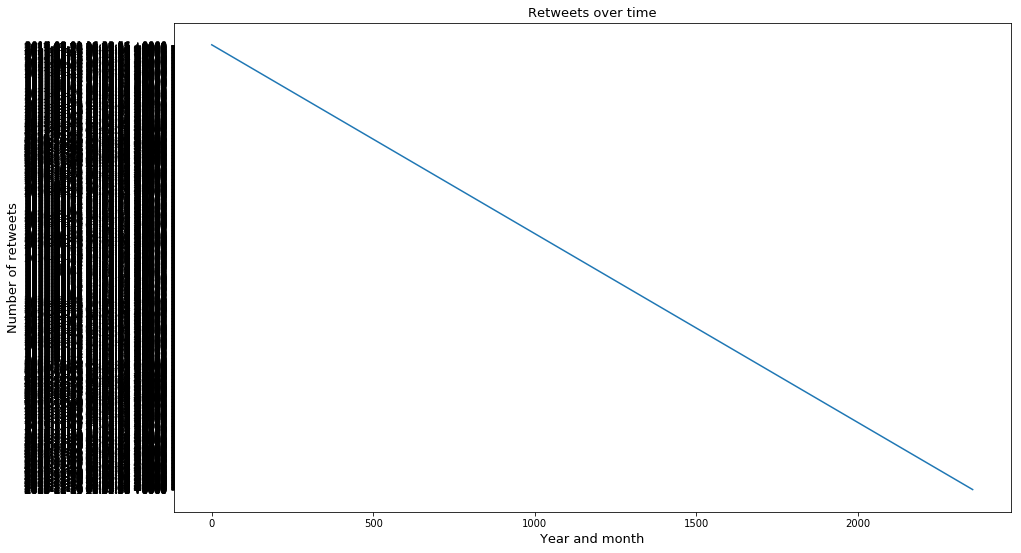

In [15]:
#plot
plt.figure(figsize=(10,5))
sns.set_context()
plt.subplots(figsize=(15, 9))
plt.plot(archive_df.timestamp,)
plt.title('Retweets over time', color = 'black', fontsize = '13')
plt.xlabel('Year and month', color = 'black', fontsize = '13')
plt.ylabel('Number of retweets', color = 'black', fontsize = '13');
plt.show()

In [195]:
pname = archive_df.name.value_counts()[1:10]

# 'a' the most popular dog name with (50).

In [196]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 13 columns):
tweet_id                      0 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     0 non-null object
source                        0 non-null object
text                          0 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 0 non-null object
rating_numerator              0 non-null int64
rating_denominator            0 non-null int64
name                          0 non-null object
dtypes: float64(4), int64(3), object(6)
memory usage: 0.0+ bytes


In [197]:
# have copy from the cleaned data 
visualize_df = archive_df.copy()